<a href="https://colab.research.google.com/github/mpa2066-spring2022/notebooks/blob/main/09_deep_learning_cats_and_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd 
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import copy
import tqdm
from PIL import Image

%matplotlib inline

In [2]:
!wget https://www.dropbox.com/sh/6sk2mq2t72zow4x/AADabkv16KXDC3E3GA2aWN9ra/cat_dog_data.tar.gz?dl=0 -O cat_dog_data.tar.gz

--2022-04-05 14:58:50--  https://www.dropbox.com/sh/6sk2mq2t72zow4x/AADabkv16KXDC3E3GA2aWN9ra/cat_dog_data.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/6sk2mq2t72zow4x/AADabkv16KXDC3E3GA2aWN9ra/cat_dog_data.tar.gz [following]
--2022-04-05 14:58:51--  https://www.dropbox.com/sh/raw/6sk2mq2t72zow4x/AADabkv16KXDC3E3GA2aWN9ra/cat_dog_data.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0e0017d257a6bc2f18e2a84e5f.dl.dropboxusercontent.com/cd/0/inline/Bi3OQrwFXwj6oM1fexJfulo1ZAlGKhwCuAMIM7aZ9soMq3SwCbKXlWeP4GFiHEHpY8fVTMlHu2JmoWikxu_bmLcdA6UxAN8UaxwJU_KgApyZvgVLWWRSLst0UkGwKHV4FkNL08BIhD2RF_DZvsKGZN8GTmodJCBXPxphC5s5z6k_Zw/file# [following]
--2022-04-05 14:58:51--  https://uc0e0017d257a6bc2f18e2a84e5f

In [ ]:
!tar -xvzf ./cat_dog_data.tar.gz

In [4]:
!rm cat_dog_data/train/._*.jpg
!rm cat_dog_data/test1/._*.jpg
# !rm cat_dog_data/train/._dog*.jpg
# !rm cat_dog_data/test1/._dog*.jpg

In [5]:
train_dir = 'cat_dog_data/train'
test_dir = 'cat_dog_data/test1'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [6]:
class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]

In [7]:

data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(128),
    transforms.ToTensor()
])

cat_files = [tf for tf in train_files if 'cat' in tf]
dog_files = [tf for tf in train_files if 'dog' in tf]

cats = CatDogDataset(cat_files, train_dir, transform = data_transform)
dogs = CatDogDataset(dog_files, train_dir, transform = data_transform)

catdogs = ConcatDataset([cats, dogs])

In [8]:
dataloader = DataLoader(catdogs, batch_size = 32, shuffle=True, num_workers=1)

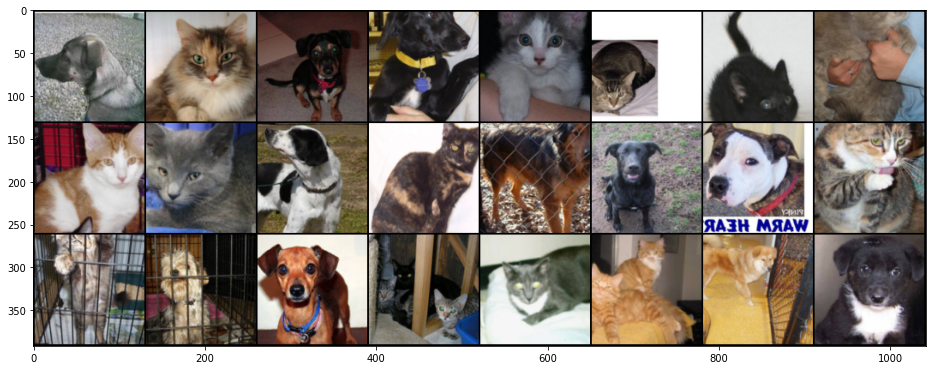

In [9]:

samples, labels = iter(dataloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()

# in tensor, image is (batch, width, height), so we have to 
# transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))



In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = torchvision.models.densenet121(pretrained=True)

In [11]:
device

'cuda'

In [12]:
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 500),
    nn.Linear(500, 2)
)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, amsgrad=True)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500], gamma=0.5)

In [13]:
epochs = 3
itr = 1
p_itr = 200
model.train()
total_loss = 0
loss_list = []
acc_list = []
for epoch in range(epochs):
    for samples, labels in dataloader:
        samples, labels = samples.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(samples)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        scheduler.step()
        
        if itr % p_itr == 0:
            pred = torch.argmax(output, dim=1)
            correct = pred.eq(labels)
            acc = torch.mean(correct.float())
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, acc))
            loss_list.append(total_loss/p_itr)
            acc_list.append(acc)
            total_loss = 0
            
        itr += 1



[Epoch 1/2] Iteration 200 -> Train Loss: 0.5108, Accuracy: 0.875
[Epoch 1/2] Iteration 400 -> Train Loss: 0.3121, Accuracy: 0.688
[Epoch 1/2] Iteration 600 -> Train Loss: 0.2545, Accuracy: 0.938
[Epoch 2/2] Iteration 800 -> Train Loss: 0.1987, Accuracy: 0.906
[Epoch 2/2] Iteration 1000 -> Train Loss: 0.1791, Accuracy: 1.000
[Epoch 2/2] Iteration 1200 -> Train Loss: 0.1475, Accuracy: 1.000
[Epoch 2/2] Iteration 1400 -> Train Loss: 0.1297, Accuracy: 0.969


In [16]:
filename_pth = 'ckpt_densenet121_catdog.pth'
torch.save(model.state_dict(), filename_pth)

test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

testset = CatDogDataset(test_files, test_dir, mode='test', transform = test_transform)
testloader = DataLoader(testset, batch_size = 32, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [17]:


model.eval()
fn_list = []
pred_list = []
for x, fn in testloader:
    with torch.no_grad():
        x = x.to(device)
        output = model(x)
        pred = torch.argmax(output, dim=1)
        fn_list += [n[:-4] for n in fn]
        pred_list += [p.item() for p in pred]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


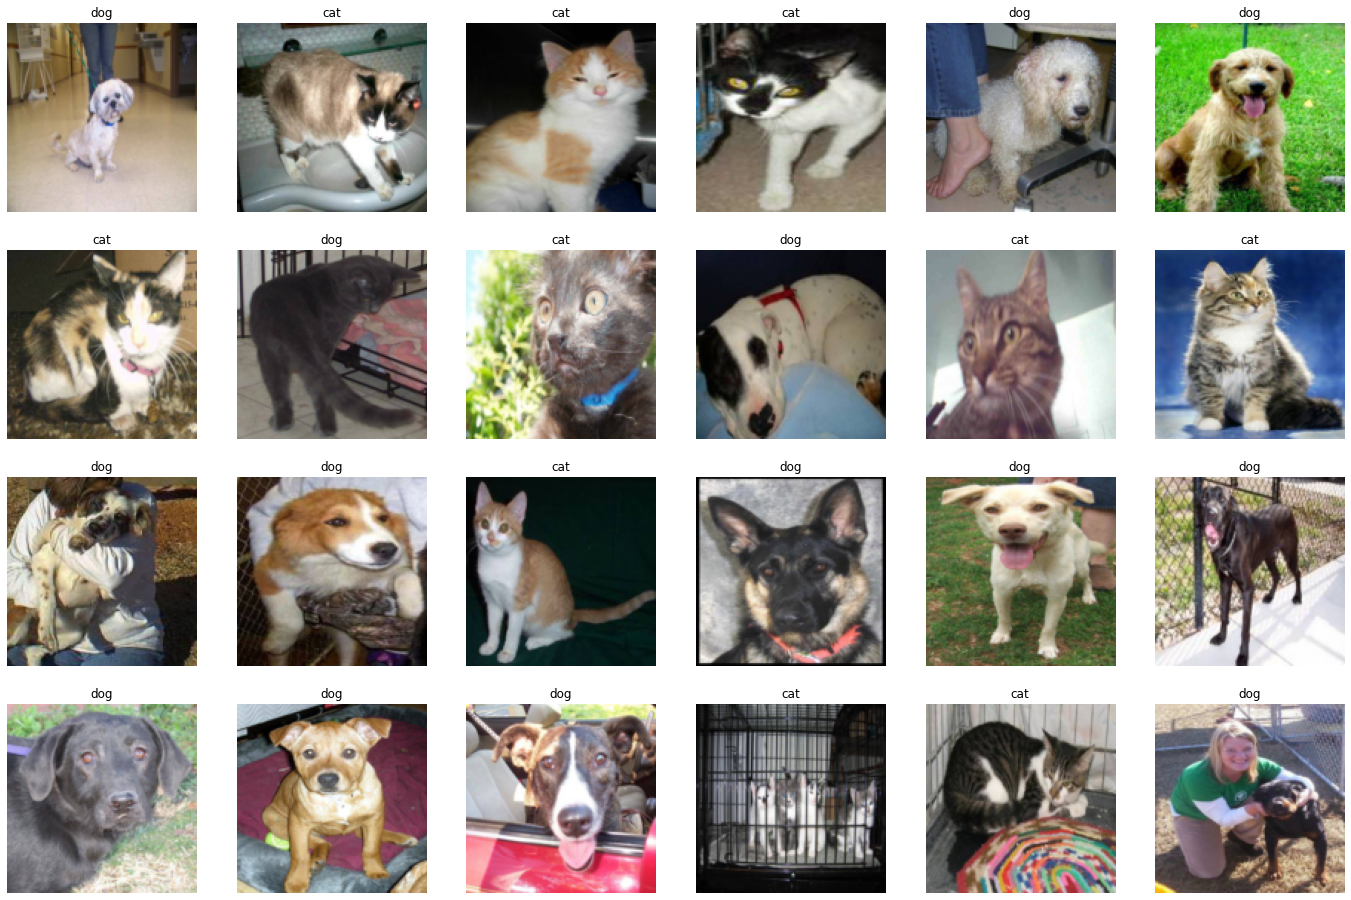

In [18]:


samples, _ = iter(testloader).next()
samples = samples.to(device)
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))

